In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Simple white noise and random walk (Brownian / Wiener process)

In [2]:
rng = np.random.default_rng()

In [3]:
n = 1000000
white_noise = rng.standard_normal(n)

<IPython.core.display.Javascript object>


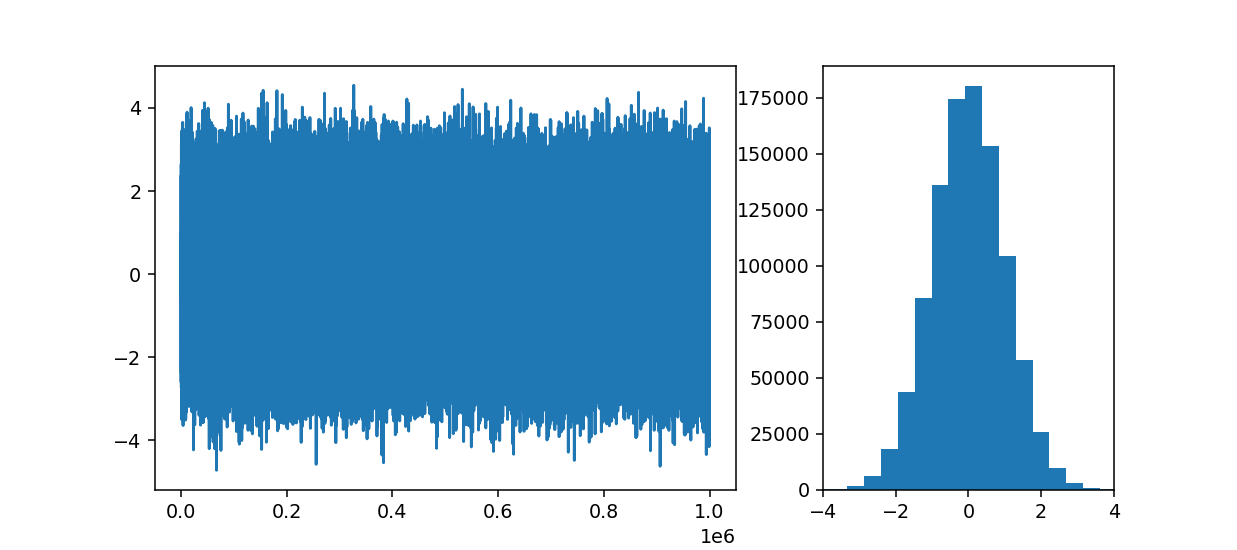

(-4.0, 4.0)

In [4]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios":[4, 2]})

ax0.plot(white_noise)

_ = ax1.hist(white_noise, bins=20)
ax1.set_xlim(-4, 4)

In [5]:
white_noise_rw = np.cumsum(white_noise)

<IPython.core.display.Javascript object>


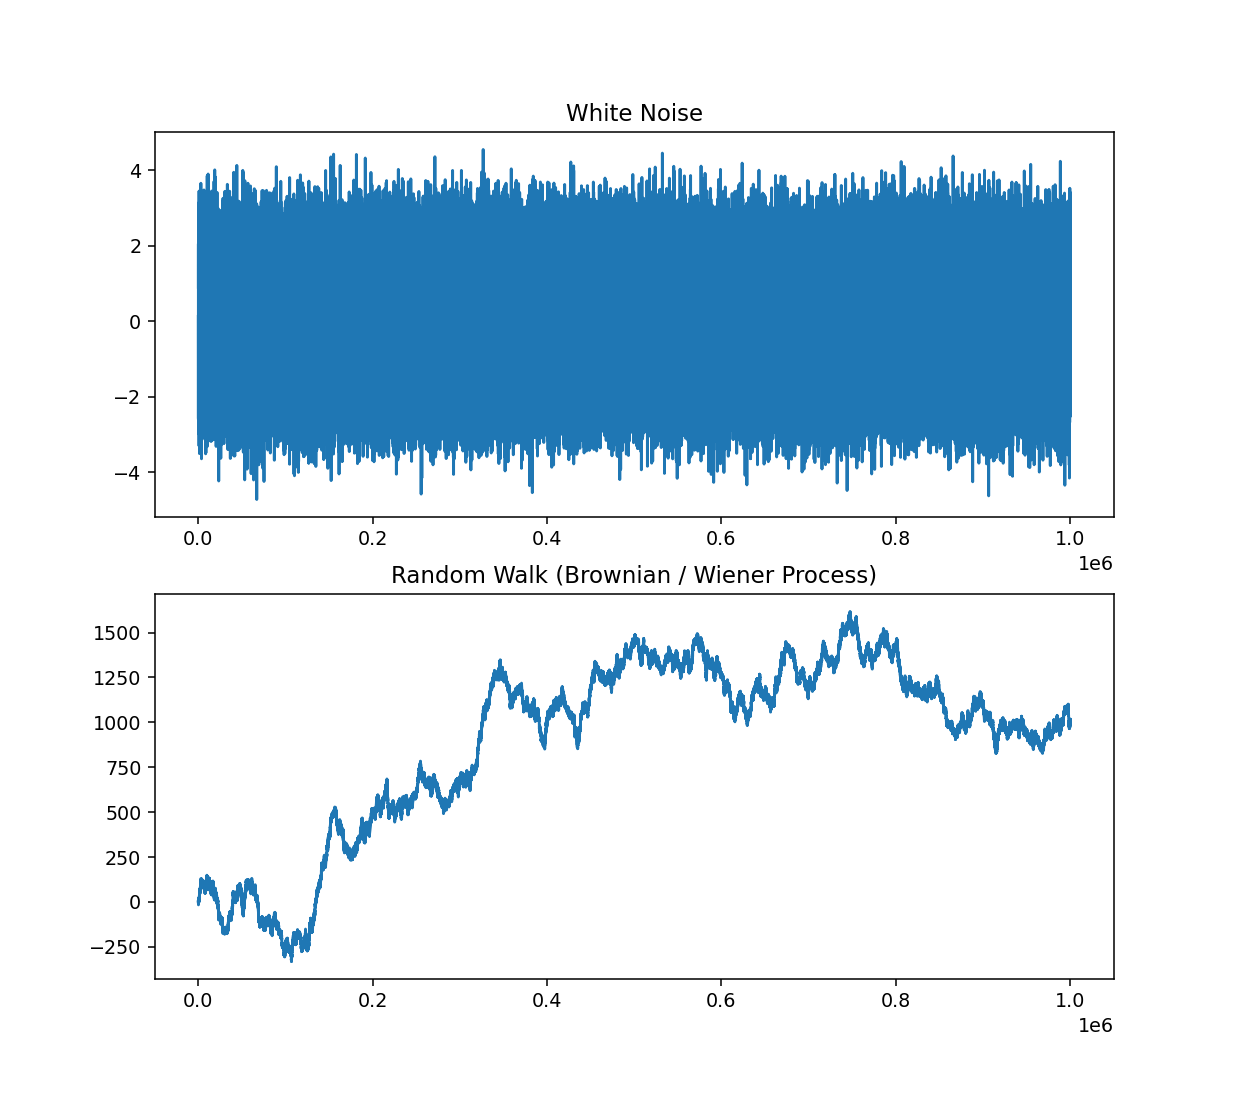

In [6]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 4*2))

ax0.set_title("White Noise")
ax0.plot(white_noise)

ax1.set_title("Random Walk (Brownian / Wiener Process)")
ax1.plot(white_noise_rw)


$\sigma_{rw} \propto \sigma \sqrt{n}$ 

In [7]:
print(f"Std white noise: {white_noise.std()}")
print(f"Std white noise RW: {white_noise_rw.std()}")
print(f"sqrt(n): {np.sqrt(n)}")

Std white noise: 0.9997185149009024
Std white noise RW: 491.2733474948447
sqrt(n): 1000.0


# Time-dependent white noise and random walk

White noise in continous-time may be expressed as:

$x\left(t\right) = \sigma \epsilon\left(t\right)$

where $\sigma$ is the process standard deviation and $\epsilon\left(t\right)$ is white noise with unit variance.

Discretizion yields:

$x_{k} = \sigma \epsilon_{k}$

It may be tempting to express a random walk as:

$\frac{x\left(t\right)}{dt} = \sigma \epsilon\left(t\right)$

However, the proper expression is:

$\frac{x\left(t\right)}{dt} = \sigma \frac{W\left(t\right)}{dt}$

where $W\left(t\right)$ is the random walk (Brownian / Wiener process) 

The subtle difference is best understood when we discretize the SDE (Stochastic differential equation):

$\frac{x\left(t\right)}{dt} = \sigma \epsilon\left(t\right) \rightarrow \frac{x_{k+1} - x_{k}}{\Delta t} = \sigma \epsilon_{k} \rightarrow x_{k+1} = x_{k} + \sigma {\Delta t} \epsilon_{k}$

whereas

$\frac{x\left(t\right)}{dt} = \sigma \frac{W\left(t\right)}{dt} \rightarrow \frac{x_{k+1} - x_{k}}{\Delta t} = \sigma \frac{W_{k+1} - W_{k}}{\Delta t} \rightarrow x_{k+1} = x_{k} + \sigma \eta_{k}$

where $\eta_{k} = W_{k+1} - W_{k}$ is i.i.d normal distributed with variance $\Delta t$

Accordingly, the proper discrete model may be expressed as:

$x_{k+1} = x_{k} + \sigma \sqrt{\Delta t} \epsilon_{k}$

Now, note that the random walk standard deviation is defined as $\sigma_{rw} = \sigma \sqrt{\Delta t}$, which yields:

Model 1:

$x_{k+1} = x_{k} + \frac{\sigma_{rw}}{\sqrt{\Delta t}} \epsilon_{k}$

or

$x_{k+1} = x_{k} + \sigma\Delta t \epsilon_{k}$

Model 2:

$x_{k+1} = x_{k} + \sigma_{rw} \epsilon_{k}$

## Simulate models ($\frac{x\left(t\right)}{dt} = \sigma \epsilon\left(t\right)$)

In [8]:
duration = 100_000.  # s
fs = 40.  # Hz
n = int(duration * fs)

sigma = 1.
t = [0.]
x1 = [0.]
x2 = [0.]

for i in range(n):
    t.append(t[-1] + 1./fs)
    
    eps = rng.standard_normal(1)[0]
    
    x1.append(x1[-1] + sigma * 1./fs * eps)
    x2.append(x2[-1] + sigma * eps)

<IPython.core.display.Javascript object>


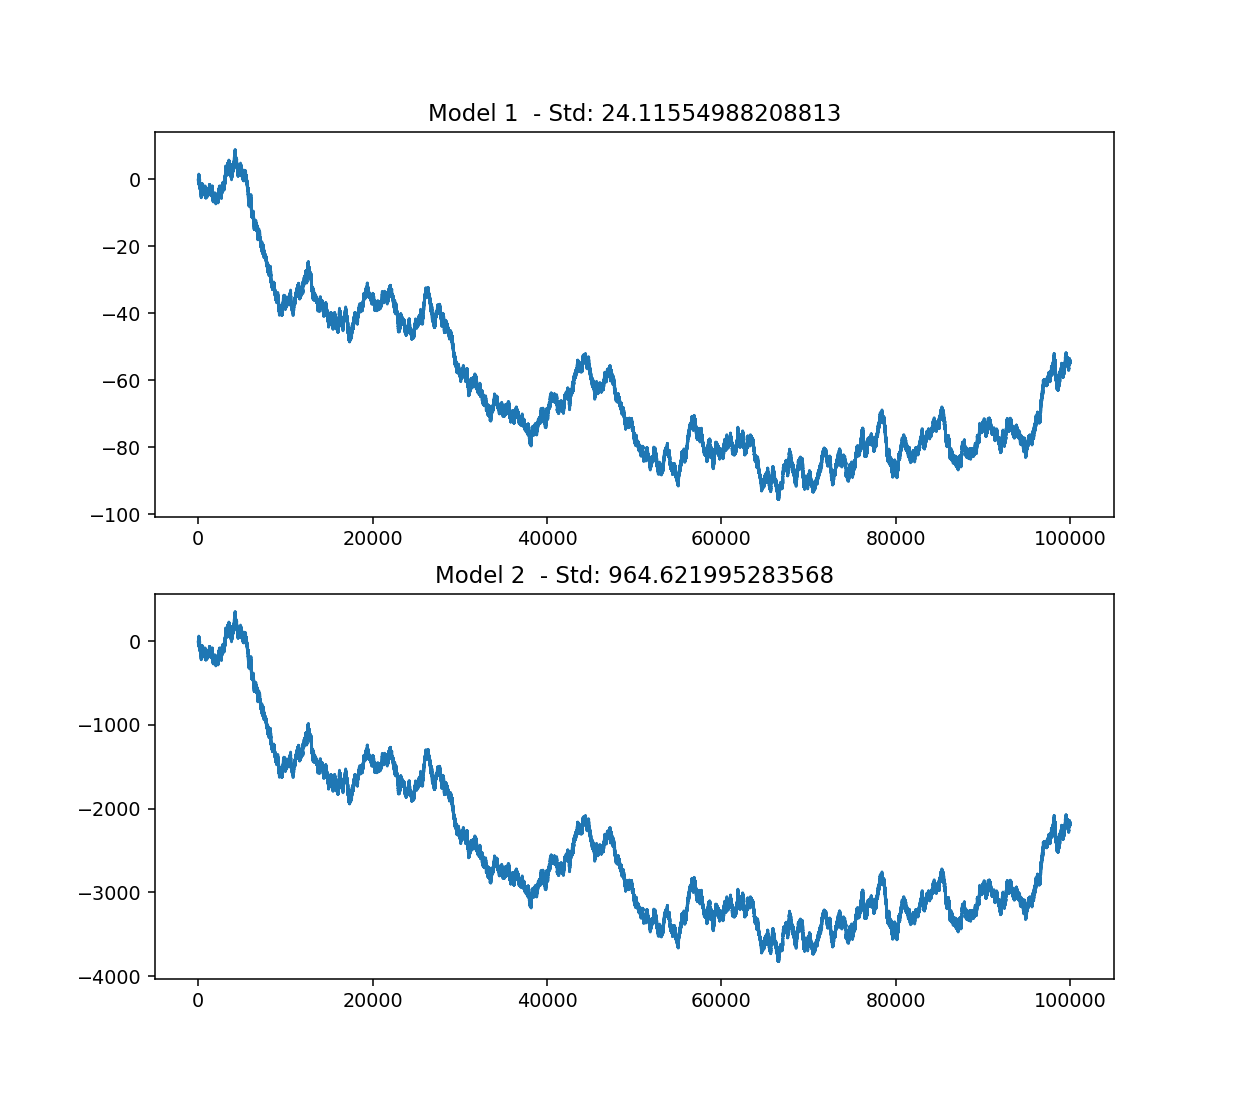

In [9]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 4*2))

ax0.set_title(f"Model 1  - Std: {np.std(x1)}")
ax0.plot(t, x1)

ax1.set_title(f"Model 2  - Std: {np.std(x2)}")
ax1.plot(t, x2)

Compare the different models by varying the sampling rate. Theoretically, increasing the sampling frequency by factor 4 should increase the random walk standard deviation by factor 2.

Model 2 have this property, whereas Model 1 exhibit the opposite trend!

In [10]:
duration = 100_000.  # s
sigma = 1.

for fs in [5., 10., 20., 40.]:  # Hz
    n = int(duration * fs)

    x1_std = []
    x2_std = []

    for j in range(25):
        t = [0.]
        x1 = [0.]
        x2 = [0.]

        for i in range(n):
            t.append(t[-1] + 1./fs)

            eps = rng.standard_normal(1)[0]

            x1.append(x1[-1] + sigma * 1./fs * eps)
            x2.append(x2[-1] + sigma * eps)

        x1_std.append(np.std(x1))
        x2_std.append(np.std(x2))

    print(f"Sampling @ {fs}")
    print(f"Model 1 std (average): {np.mean(x1_std)}")
    print(f"Model 2 std (average): {np.mean(x2_std)}")

Sampling @ 5.0
Model 1 std (average): 46.134517594048866
Model 2 std (average): 230.6725879702452
Sampling @ 10.0
Model 1 std (average): 35.74766147446546
Model 2 std (average): 357.47661474465195
Sampling @ 20.0
Model 1 std (average): 24.406218475895777
Model 2 std (average): 488.12436951791443
Sampling @ 40.0
Model 1 std (average): 20.159714393152168
Model 2 std (average): 806.3885757260947


## 1st order Gauss-Markov models

1st order Gauss-Markov models may be used to model more "complicated" noise and error sources; resamble random walk in short-term, but are bounded in long-term. Typically, 1st order Gauss-Markov models are used to approximate "flicker" noise.

In continuous-time, the 1st order Gauss-Markov model is defined as:

$\frac{dx\left(t\right)}{dt} = \beta x\left(t\right) + \epsilon\left(t\right)$

which is an SDE.

The relation between white noise variance (short-term) and the process (long-term) variance may be expressed as:

$\sigma_{x}^2 = \frac{\sigma^2 \Delta t}{1 - e^{-2\beta\Delta t}} = \frac{\sigma_{rw}^2}{1 - e^{-2\beta\Delta t}}$

This relationship is derived directly from AR(1) process, see https://en.wikipedia.org/wiki/Autoregressive_model

Accordingly, for the continuous case:

$\lim_{\Delta t \to 0} \sigma_{x}^2 = \frac{\sigma^2 \Delta t}{2\beta\Delta t}$

1st order Gauss-Markov models can be viewed as short-term random walks which are bound in the long-term. See example below where the 1st order Gauss-Markov can be compared to a random walk.

In [11]:
duration = 25000.  # s (increase/decrease to see effect of short-/long-term effects)
fs = 10.  # Hz
n = int(duration * fs)
tc = 50.  # low value -> white noise | high value -> random walk (bounded)

sigma = 1.
t = [0.]
x1 = [0.]
x2 = [0.]


for i in range(n):
    t.append(t[-1] + 1./fs)
    
    eps = rng.standard_normal(1)[0]
    
    x1.append((1. - 1./(fs*tc)) * x1[-1] + sigma * np.sqrt(1. - np.exp(-2./(fs*tc))) * eps)
    x2.append(x2[-1] + sigma * eps)

<IPython.core.display.Javascript object>


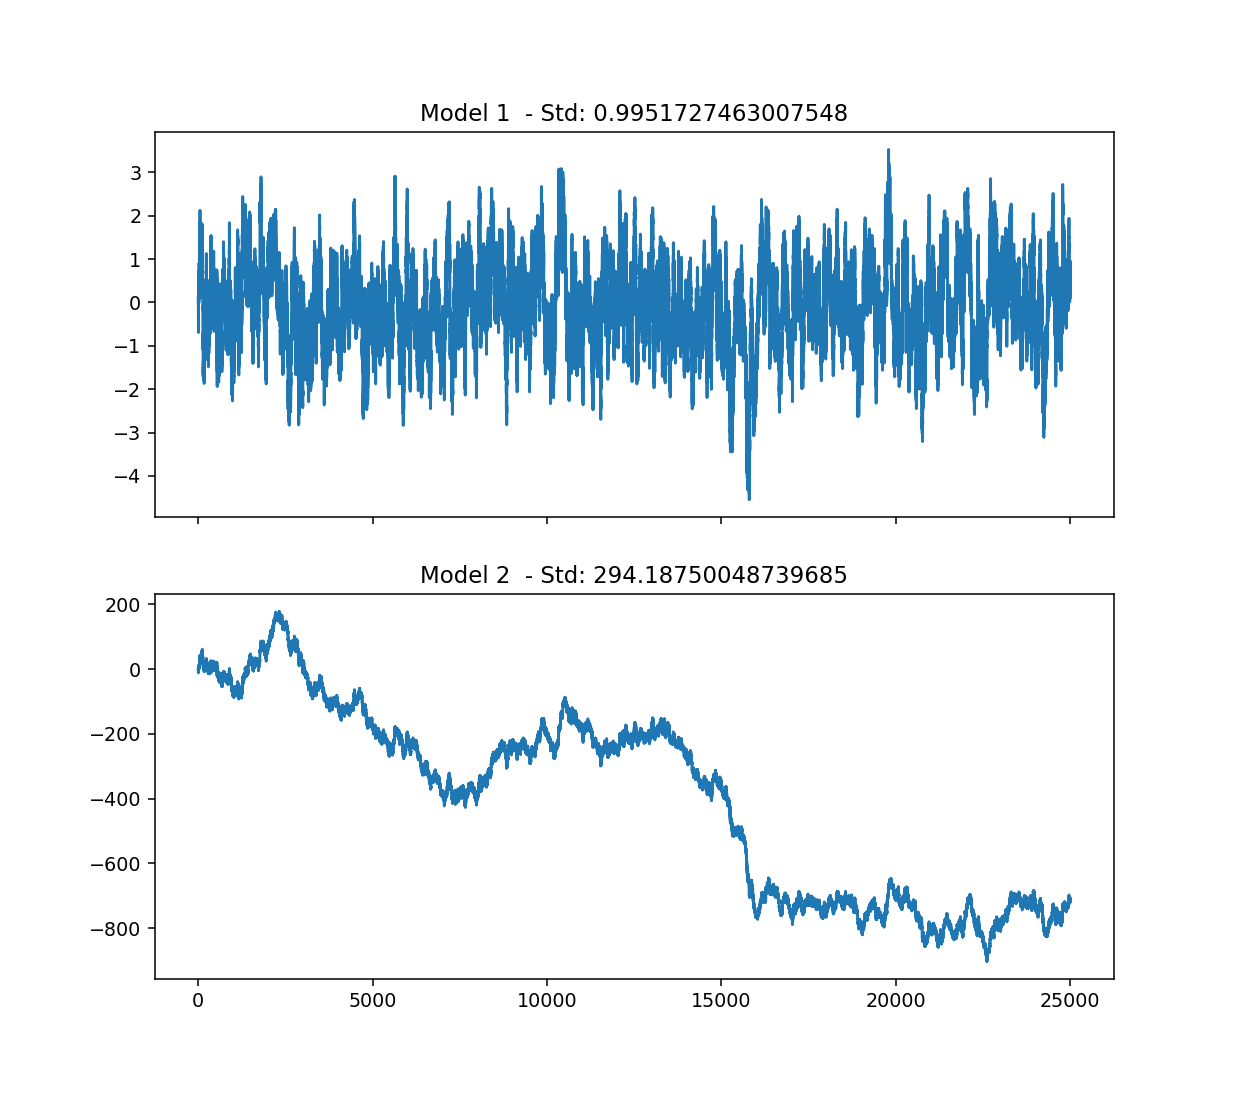

In [12]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(9, 4*2), sharex=True)

ax0.set_title(f"Model 1  - Std: {np.std(x1)}")
ax0.plot(t, x1)

ax1.set_title(f"Model 2  - Std: {np.std(x2)}")
ax1.plot(t, x2)

1st order Gauss-Markov models can also be used to approximate flicker noise at specific frequencies; the model will transition from white noise to random walk, and in the intermediate region it will resemble flicker noise.

<IPython.core.display.Javascript object>


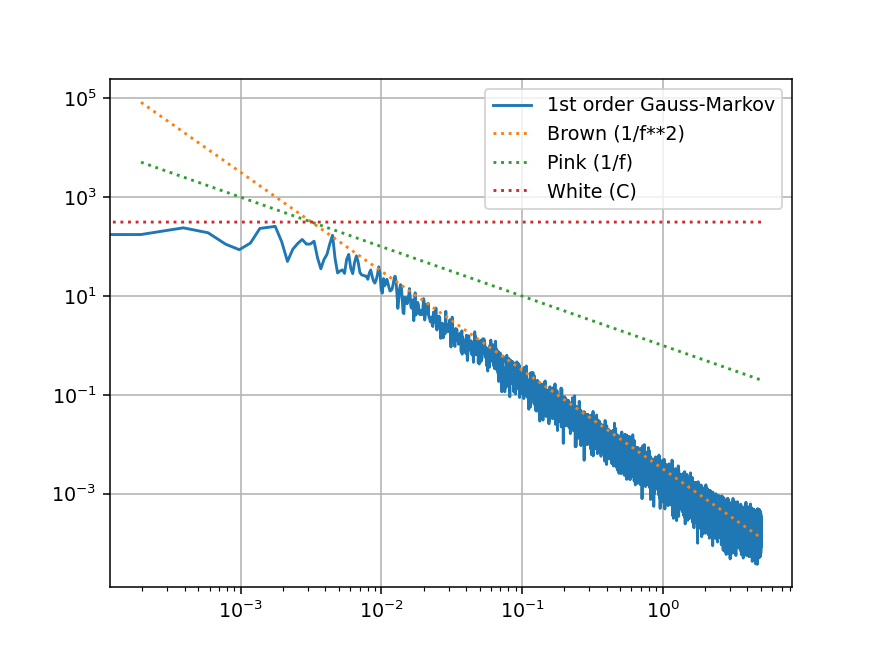

c:\users\ace\workspace\noise_error_models\.venv\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
c:\users\ace\workspace\noise_error_models\.venv\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [13]:
f, ps = signal.welch(x1, 10., nperseg=1024*50)

plt.figure()
plt.loglog(f, ps, label="1st order Gauss-Markov")

scale = tc * 2.*np.pi  # arbitrary

plt.loglog(f, (1./scale)/f**2, ":", label="Brown (1/f**2)")
plt.loglog(f, 1/f**1, ":", label="Pink (1/f)")
plt.loglog(f, scale/f**0, ":", label="White (C)")
plt.grid()
plt.legend()